## Research Question

"How does COVID-19 vaccination status influence self-reported life satisfaction among individuals?"

## Analysis Proposal

I will perform a simple linear regression with hypothesis testing to check the association.

<br>

$Life Satisfaction=\beta _0 + \beta _1 * Vaccination Status$

$H_0$: $\beta _1=0$ (there is no significant relationship between COVID-19 vaccination status and life satisfaction)
<br>$H_1$: $\beta _1≠0$ (COVID-19 vaccination status significantly influences life satisfaction)

## Organize Data

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the data
df = pd.read_csv('CSCS_data_anon.csv', low_memory=False)

# Select relevant features
features = ["WELLNESS_life_satisfaction", "COVID_vaccinated"]
df = df[features]

# Normalize WELLNESS_life_satisfaction using MinMaxScaler
scaler = MinMaxScaler()
df["WELLNESS_life_satisfaction_normalized"] = scaler.fit_transform(df[["WELLNESS_life_satisfaction"]])

# Map COVID_vaccinated to the specified values
vaccination_mapping = {
    "No": 0,
    "Yes, one dose": 1,
    "Yes, two doses": 2,
    "Yes, three or more doses": 3
}
df["COVID_vaccinated"] = df["COVID_vaccinated"].map(vaccination_mapping)

df["COVID_vaccinated_normalized"] = scaler.fit_transform(df[["COVID_vaccinated"]])

df_cleaned = df.dropna(subset=["COVID_vaccinated_normalized", "WELLNESS_life_satisfaction_normalized"])

x = df_cleaned["COVID_vaccinated_normalized"]
y = df_cleaned["WELLNESS_life_satisfaction_normalized"]

df_cleaned = df_cleaned[~x.isnull() | ~y.isnull()]

x = df_cleaned["COVID_vaccinated_normalized"]
y = df_cleaned["WELLNESS_life_satisfaction_normalized"]

# Display the first few rows of the processed data
print(df_cleaned.head())
print("\nEffective Data Amount: " + str(len(df_cleaned)))

   WELLNESS_life_satisfaction  COVID_vaccinated  \
0                         2.0               3.0   
1                         7.0               3.0   
2                         5.0               3.0   
3                         4.0               3.0   
4                         8.0               1.0   

   WELLNESS_life_satisfaction_normalized  COVID_vaccinated_normalized  
0                               0.111111                     1.000000  
1                               0.666667                     1.000000  
2                               0.444444                     1.000000  
3                               0.333333                     1.000000  
4                               0.777778                     0.333333  

Effective Data Amount: 7398


To organize the data, we have to
- normalize the outcome variable `WELLNESS_life_satisfaction` and the predictor variable `COVID_vaccinated`
- drop all empty data points

Then, I will apply the linear regression `ols` on `WELLNESS_life_satisfaction_normalized` ($Y$) and `COVID_vaccinated_normalized` ($x$).

## Linear Regression

                                      OLS Regression Results                                     
Dep. Variable:     WELLNESS_life_satisfaction_normalized   R-squared:                       0.008
Model:                                               OLS   Adj. R-squared:                  0.008
Method:                                    Least Squares   F-statistic:                     58.47
Date:                                   Sat, 23 Nov 2024   Prob (F-statistic):           2.33e-14
Time:                                           23:19:43   Log-Likelihood:                -574.50
No. Observations:                                   7398   AIC:                             1153.
Df Residuals:                                       7396   BIC:                             1167.
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

c:\Users\chenh\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


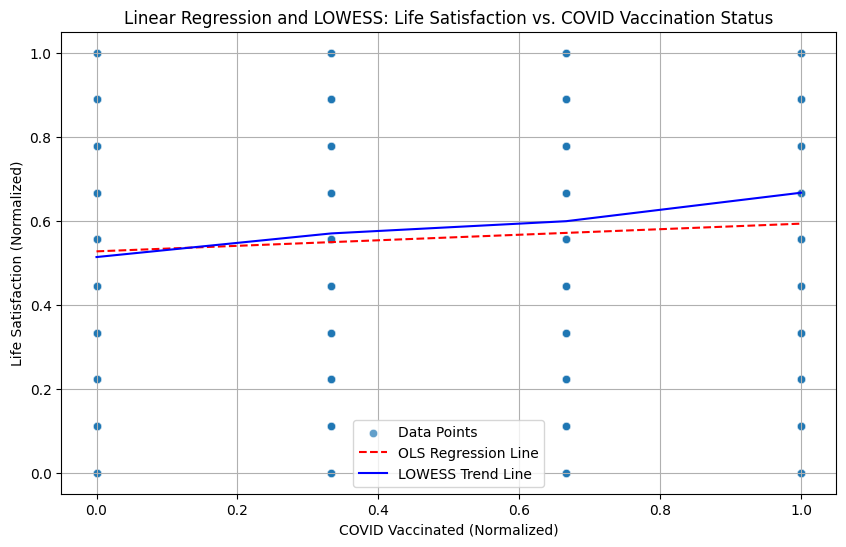

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Add a constant for the intercept
x_with_const = sm.add_constant(x)

# Perform OLS regression
model = sm.OLS(y, x_with_const)
results = model.fit()

# Print the summary of the regression
print(results.summary())

# Visualization (remains unchanged)
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(x=x, y=y, alpha=0.7, label="Data Points")

# Plot regression line
x_range = np.linspace(x.min(), x.max(), 100)
y_pred = results.predict(sm.add_constant(x_range))
plt.plot(x_range, y_pred, color="red", label="OLS Regression Line", linestyle="--")

# Add LOWESS trend line
lowess_smoothed = lowess(y, x, frac=0.3)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color="blue", label="LOWESS Trend Line")

# Customize plot
plt.xlabel("COVID Vaccinated (Normalized)")
plt.ylabel("Life Satisfaction (Normalized)")
plt.title("Linear Regression and LOWESS: Life Satisfaction vs. COVID Vaccination Status")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Hypothesis Testing

### A List of Important Numbers
- $\beta _0$ = 0.5271
- $\beta _1$ = 0.0660
- p-value for $\beta _1$ < 0.001

As a result, we got a low p-value which provides very strong evidence against our $H_0$ (there is no significant relationship between COVID-19 vaccination status and life satisfaction).
The result somewhat implies $H_1$ (COVID-19 vaccination status significantly influences life satisfaction).

## Evaluation of the Model

However, $R^2$ only equals 0.008 which is 0.8%. In other words, the predictor variable explains only 0.8% of the variation in the dependent variable. 98.2% of the variability in life satisfaction is unexplained by the model, and could be attributed to factors not included in the model or random variation.

Possible Reasons for Low R-squared:
- Other Variables: Life satisfaction is likely influenced by many factors beyond vaccination status (e.g., socioeconomic status, mental health, etc.), which are not included in this model.
- Data Issues: There may be issues with how the data is encoded or structured.

Nevertheless, the low p-value still confirms the strong association between our two variables.



# Alternative Approach

To handle the second concern in the model evaluation. I will treat `COVID_vaccinated` as a categorical variable to perform a multiple linear regression with indicator variables again.

In [15]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the data
df = pd.read_csv('CSCS_data_anon.csv', low_memory=False)

# Select relevant features
features = ["WELLNESS_life_satisfaction", "COVID_vaccinated"]
df = df[features]

# Normalize WELLNESS_life_satisfaction using MinMaxScaler
scaler = MinMaxScaler()
df["WELLNESS_life_satisfaction_normalized"] = scaler.fit_transform(df[["WELLNESS_life_satisfaction"]])

# Define the vaccination mapping
vaccination_mapping = {
    "No": 0,
    "Yes, one dose": 1,
    "Yes, two doses": 2,
    "Yes, three or more doses": 3
}

# Apply the mapping to the COVID_vaccinated column
df['COVID_vaccinated_encoded'] = df['COVID_vaccinated'].map(vaccination_mapping)

# Drop rows with missing values in either 'WELLNESS_life_satisfaction_normalized' or 'COVID_vaccinated_encoded'
df_cleaned = df.dropna(subset=['WELLNESS_life_satisfaction_normalized', 'COVID_vaccinated_encoded'])

# Formula with dummy/indicator variables for each group (no interaction)
formula = 'WELLNESS_life_satisfaction_normalized ~ C(COVID_vaccinated_encoded)'

# Perform the OLS regression using statsmodels.formula.api
model = smf.ols(formula=formula, data=df_cleaned)
results = model.fit()

# Print the summary of the regression
print(results.summary())

                                      OLS Regression Results                                     
Dep. Variable:     WELLNESS_life_satisfaction_normalized   R-squared:                       0.010
Model:                                               OLS   Adj. R-squared:                  0.010
Method:                                    Least Squares   F-statistic:                     25.28
Date:                                   Sat, 23 Nov 2024   Prob (F-statistic):           2.89e-16
Time:                                           23:38:18   Log-Likelihood:                -565.88
No. Observations:                                   7398   AIC:                             1140.
Df Residuals:                                       7394   BIC:                             1167.
Df Model:                                              3                                         
Covariance Type:                               nonrobust                                         
                    

As we can see now, $R^2$ is improved from 0.8% to 1%, which means that multiple linear regression improves the explanatory ability of the model a little bit. Moreover, p-values are still very low and provide strong evidence.